In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg
import sdeint

Рассмотрим точность решения на основе уравнения с известным решением:
$$
\boldsymbol{x}(t) = \exp\left\{ \hat{A}t\right\} \exp\left\{\hat{B}W\right\}\boldsymbol{x}_0
$$
На основе формулы Ито конструируем стохастическое дифференциальное уравнение с таким решением:
$$
d\boldsymbol{x} = \left(\hat{A} + \dfrac{1}{2} e^{\hat{A}t}\hat{B}^2 e^{-\hat{A}t} \right)\boldsymbol{x} dt + e^{\hat{A}t}\hat{B}e^{-\hat{A}t}\boldsymbol{x}dW  
$$
Положим здесь:
$$
\hat{A} = \begin{pmatrix}
-\frac{1}{10} & -2\\
2 & -\frac{1}{10}
\end{pmatrix},  \qquad \hat{B} = \begin{pmatrix}
0 & -0.1\\
0.1 & -0.1
\end{pmatrix}
$$

In [2]:
A = np.array([[-0.1, -2.0],
              [ 2.0, -0.1]])

B = 10*np.array([[0., -0.01],
              [ 0.01, -0.01]])

tspan = np.linspace(0.0, 10.0, 100001)
dt = tspan[1:] - tspan[:-1]
#dW = np.random.normal(size=(len(tspan)-1, 2))*np.reshape(np.sqrt(dt), (-1,1))
dW = sdeint.deltaW(len(tspan)-1, 1, dt[0])
#dW[np.logical_not(np.logical_or(np.logical_and(tspan[1:] > 13*np.pi/12, tspan[1:] < 14*np.pi/12), np.logical_and(tspan[1:] > 7*np.pi/12, tspan[1:] < 8*np.pi/12)))] = 0.
x0 = np.array([3.0, 0.0])

In [3]:
# Exact solution
W = np.vstack(([0.], np.cumsum(dW, axis=0)))
x_th = np.array([linalg.expm(A*t) @ linalg.expm(B*w) @ x0 for t,w in zip(tspan, W)])

In [4]:
def Iwik_wrapper(dW, h, generator=None):
    n = int(np.ceil(np.sqrt(1/h)))
    print(n)
    return sdeint.Iwik(dW, h, n=n, generator=generator)

In [5]:
def f(x, t):
    return (A + 0.5*linalg.expm(A*t) @ B**2 @ linalg.expm(-A*t)) @ x

def G(x, t):
    return (linalg.expm(A*t) @ B @ linalg.expm(-A*t) @ x).reshape(2,1)
    #return np.array([B_1@x, B_2@x])

x_eu = sdeint.itoEuler(f, G, x0, tspan, dW=dW)
x_sri = sdeint.itoSRI2(f, G, x0, tspan, Imethod=Iwik_wrapper, dW=dW)

100


In [6]:
x_impl = []
x_impl.append(x0)
x_c = x0
delt = dt[0]
for tt, deltw in zip(tspan, dW):
    x_c = linalg.solve((np.identity(2) - (A + 0.5*linalg.expm(A*(tt+delt)) @ B**2 @ linalg.expm(-A*(tt+delt)))*delt - 
                                          linalg.expm(A*(tt+delt)) @ B @ linalg.expm(-A*(tt+delt))*deltw), x_c)  
    x_impl.append(x_c)
    
x_impl = np.array(x_impl)

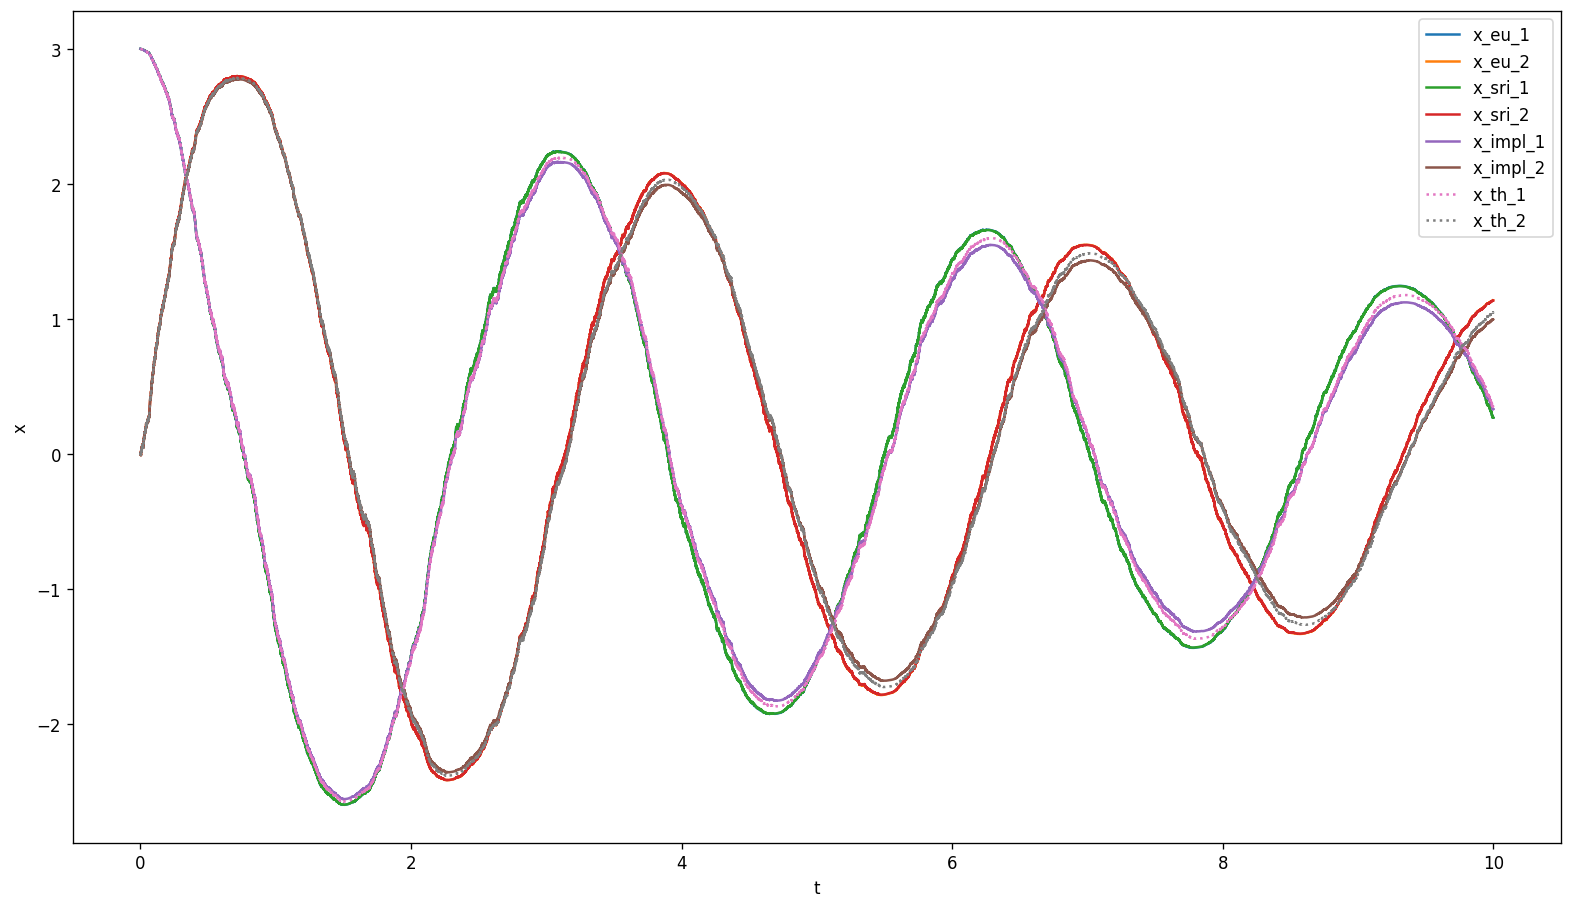

In [7]:
plt.figure(figsize=(16, 9), dpi=120)
plt.plot(tspan, x_eu, label=("x_eu_1", "x_eu_2"))
plt.plot(tspan, x_sri, label=("x_sri_1", "x_sri_2"))
plt.plot(tspan, x_impl, label=("x_impl_1", "x_impl_2"))
plt.plot(tspan, x_th, ":", label=("x_th_1", "x_th_2"))
plt.legend(loc="upper right")
plt.xlabel("t")
plt.ylabel("x")
plt.show()

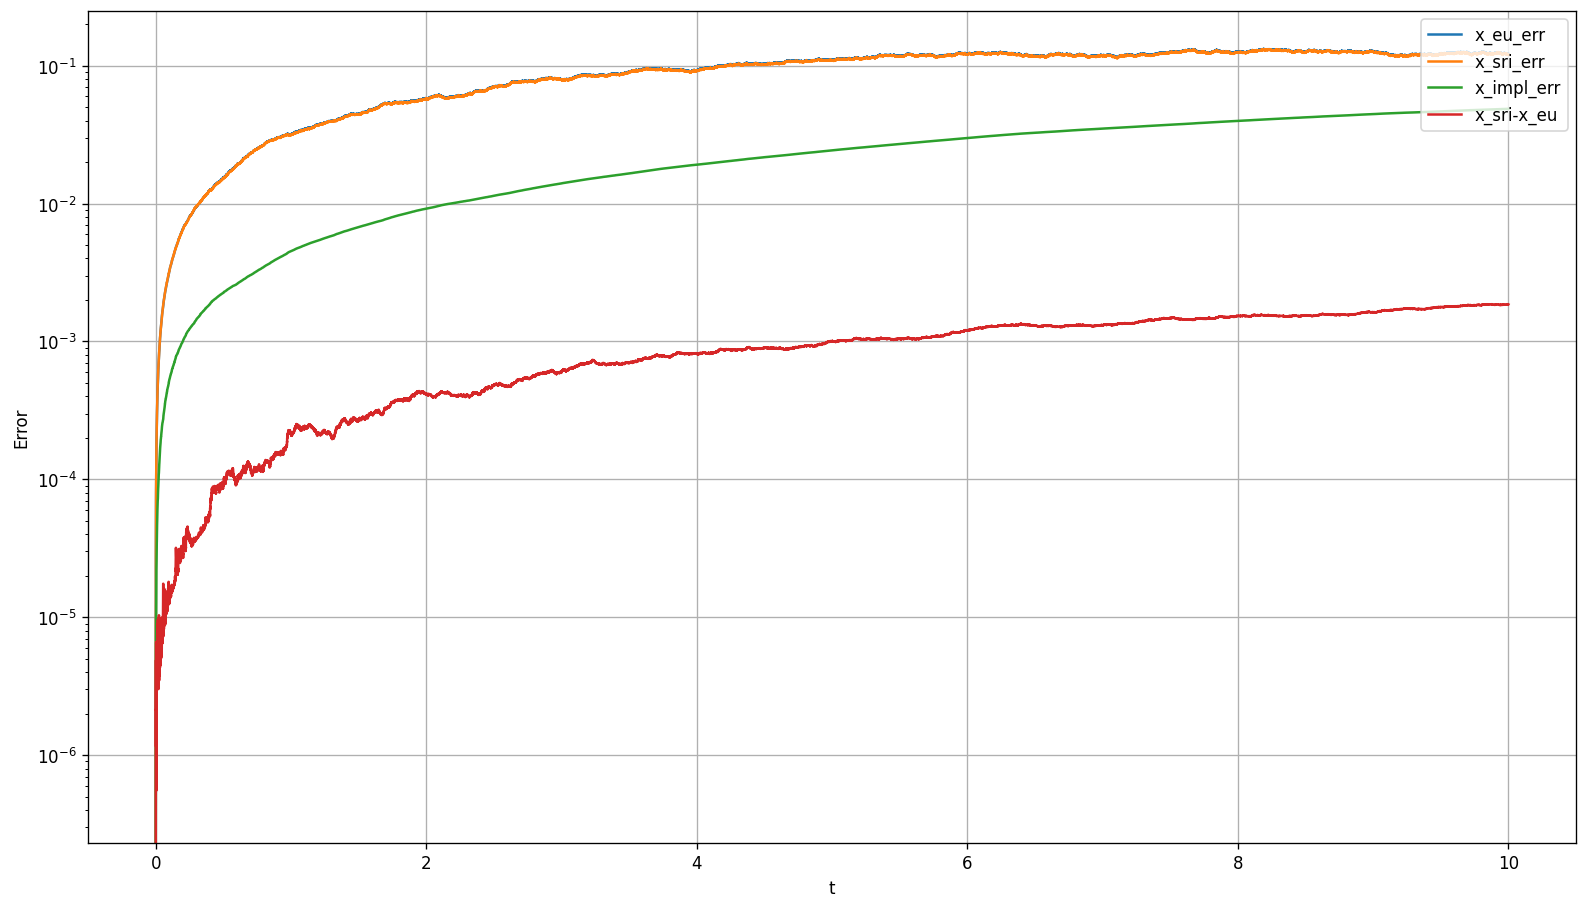

In [8]:
plt.figure(figsize=(16, 9), dpi=120)
plt.plot(tspan, np.linalg.norm(x_eu-x_th, axis=1), label="x_eu_err")
plt.plot(tspan, np.linalg.norm(x_sri-x_th, axis=1), label="x_sri_err")
plt.plot(tspan, np.linalg.norm(x_impl-x_th, axis=1)/np.linalg.norm(x_th, axis=1), label="x_impl_err")
plt.plot(tspan, np.linalg.norm(x_sri-x_eu, axis=1)/np.linalg.norm(x_th, axis=1), label="x_sri-x_eu")
plt.yscale("log")
#plt.ylim((1e-3, 10))
plt.grid()
plt.legend(loc="upper right")
plt.xlabel("t")
plt.ylabel("Error")
plt.show()

Видно, что численное решение в принципе сходится с теоретическим расчетом. На графике выше под ошибкой понимается величина (2-норма отклонения):
$$
x_\text{err} = \sqrt{(x_1 - x_{\text{th}1})^2 + (x_2 - x_{\text{th}2})^2 }
$$

Давайте проанализируем зависимость точности решения от уровня шума:

$$
\hat{B} = M\cdot \begin{pmatrix}
0 & -1 \\
1 & -1
\end{pmatrix}
$$

Будем строить зависимость максимальной 2-нормы отклонения от $M$.

In [9]:
Nmult = np.logspace(-7, 0.5, 10)

eu_err = []
impl_err = []
sriIw_err = []
sri_err = []

tspan = np.linspace(0.0, 10.0, 10001)
dt = tspan[1:] - tspan[:-1]
dW = sdeint.deltaW(len(tspan)-1, 1, dt[0])
W = np.vstack(([0.], np.cumsum(dW, axis=0)))
x0 = np.array([3.0, 0.0])

for multa in Nmult:
    B = multa*np.array([[0., -1.],
                        [ 1., -1.]])
    x_th = np.array([linalg.expm(A*t) @ linalg.expm(B*w) @ x0 for t,w in zip(tspan, W)])
    
    def fb(x, t):
        return (A + 0.5*linalg.expm(A*t) @ B**2 @ linalg.expm(-A*t)) @ x

    def Gb(x, t):
        return (linalg.expm(A*t) @ B @ linalg.expm(-A*t) @ x).reshape(2,1)
    
    x_eu = sdeint.itoEuler(f, G, x0, tspan, dW=dW)
    x_sriIw = sdeint.itoSRI2(f, G, x0, tspan, Imethod=Iwik_wrapper, dW=dW)
    x_sri = sdeint.itoSRI2(f, G, x0, tspan, Imethod=sdeint.Iwik, dW=dW)
    
    x_impl = []
    x_impl.append(x0)
    x_c = x0
    delt = dt[0]
    for tt, deltw in zip(tspan, dW):
        x_c = linalg.solve((np.identity(2) - (A + 0.5*linalg.expm(A*(tt+delt)) @ B**2 @ linalg.expm(-A*(tt+delt)))*delt - 
                                              linalg.expm(A*(tt+delt)) @ B @ linalg.expm(-A*(tt+delt))*deltw), x_c)  
        x_impl.append(x_c)

    x_impl = np.array(x_impl)
    
    eu_err.append(np.linalg.norm(x_eu-x_th, axis=1).max())
    sri_err.append(np.linalg.norm(x_sri-x_th, axis=1).max())
    impl_err.append(np.linalg.norm(x_impl-x_th, axis=1).max())
    sriIw_err.append(np.linalg.norm(x_sriIw-x_th, axis=1).max())

32
32
32
32
32
32
32
32
32
32


Ошибки лезут из-за расходимости методов при больших значениях шума. Графики: 

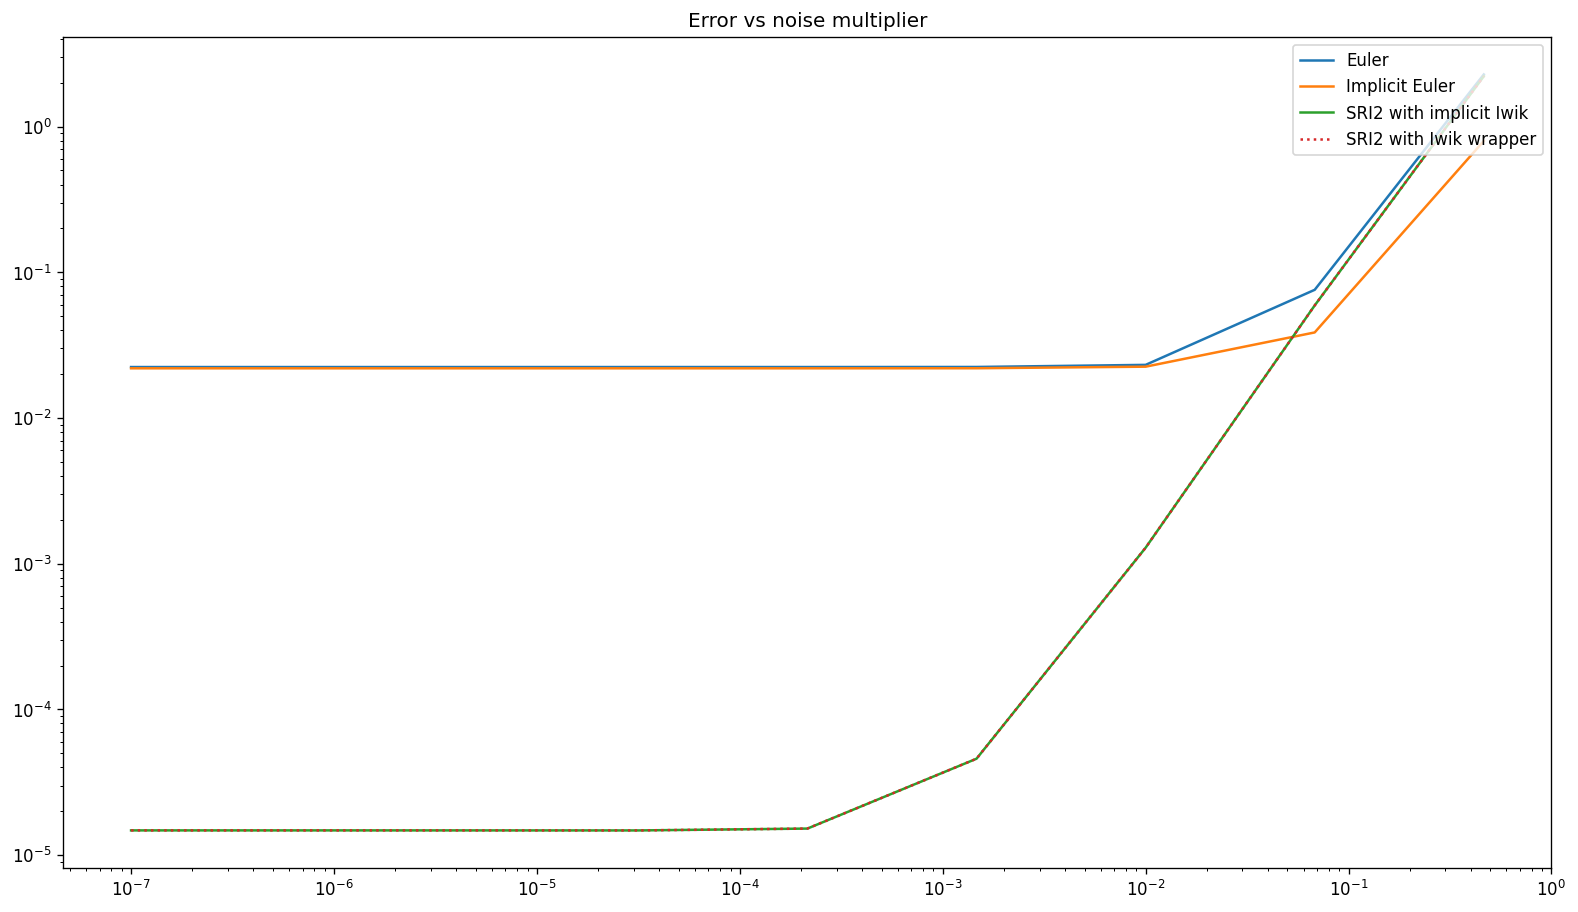

In [10]:
plt.figure(figsize=(16, 9), dpi=120)
plt.plot(Nmult[:-1], eu_err[:-1], label="Euler")
plt.plot(Nmult[:-1], impl_err[:-1], label="Implicit Euler")
plt.plot(Nmult[:-1], sri_err[:-1], label="SRI2 with implicit Iwik")
plt.plot(Nmult[:-1], sriIw_err[:-1], ":", label="SRI2 with Iwik wrapper")
plt.yscale("log")
plt.xscale("log")
plt.legend(loc='upper right')
plt.title("Error vs noise multiplier")
plt.savefig("Error vs noise multiplier.pdf")

Видно, во-первых, что ручной выбор числа итераций для вычисления кратных интегралов ИТО не влияет на точность. Во-вторых, при шумах порядка $10^{-3}\div10^{-4}$ можно считать диффур классическим. Соответствено, интересные для исследования области - это шум в пределах $10^{-3}\div 10^0$.

Теперь поварьируем шаг времени. Сделаем это для уровней шумов: $10^{-4}\div10^{-1}$

In [11]:
Nnoise = 4
Nt = 10

Noiseamps = np.logspace(-4, -1, Nnoise)
dts = np.logspace(-4, -1, Nt)

Namp, Dt = np.meshgrid(Noiseamps, dts)
itlist = [(Na, dt) for Na, dt in zip(Namp.flatten(), Dt.flatten())]

In [12]:
from multiprocessing import Pool
from find_err import find_errs
import time

In [13]:
start = time.time()
if __name__ == "__main__":
    with Pool(processes=16) as pool:
        result_errs = pool.starmap(find_errs, itlist)
end = time.time()
print("Time elapsed: {:.10f} ms".format((end-start)*1000))

Time elapsed: 251369.1532611847 ms


In [14]:
eu_res_err = (np.array(result_errs)[:,0]).reshape(Dt.shape)
sri_res_err = (np.array(result_errs)[:,1]).reshape(Dt.shape)
impl_res_err = (np.array(result_errs)[:,2]).reshape(Dt.shape)
sriIw_res_err = (np.array(result_errs)[:,3]).reshape(Dt.shape)

data = [eu_res_err, sri_res_err, impl_res_err, sriIw_res_err]
names = ["Euler", "SRI2", "Euler Implicit", "SRI2 with Iwik wrapper"]

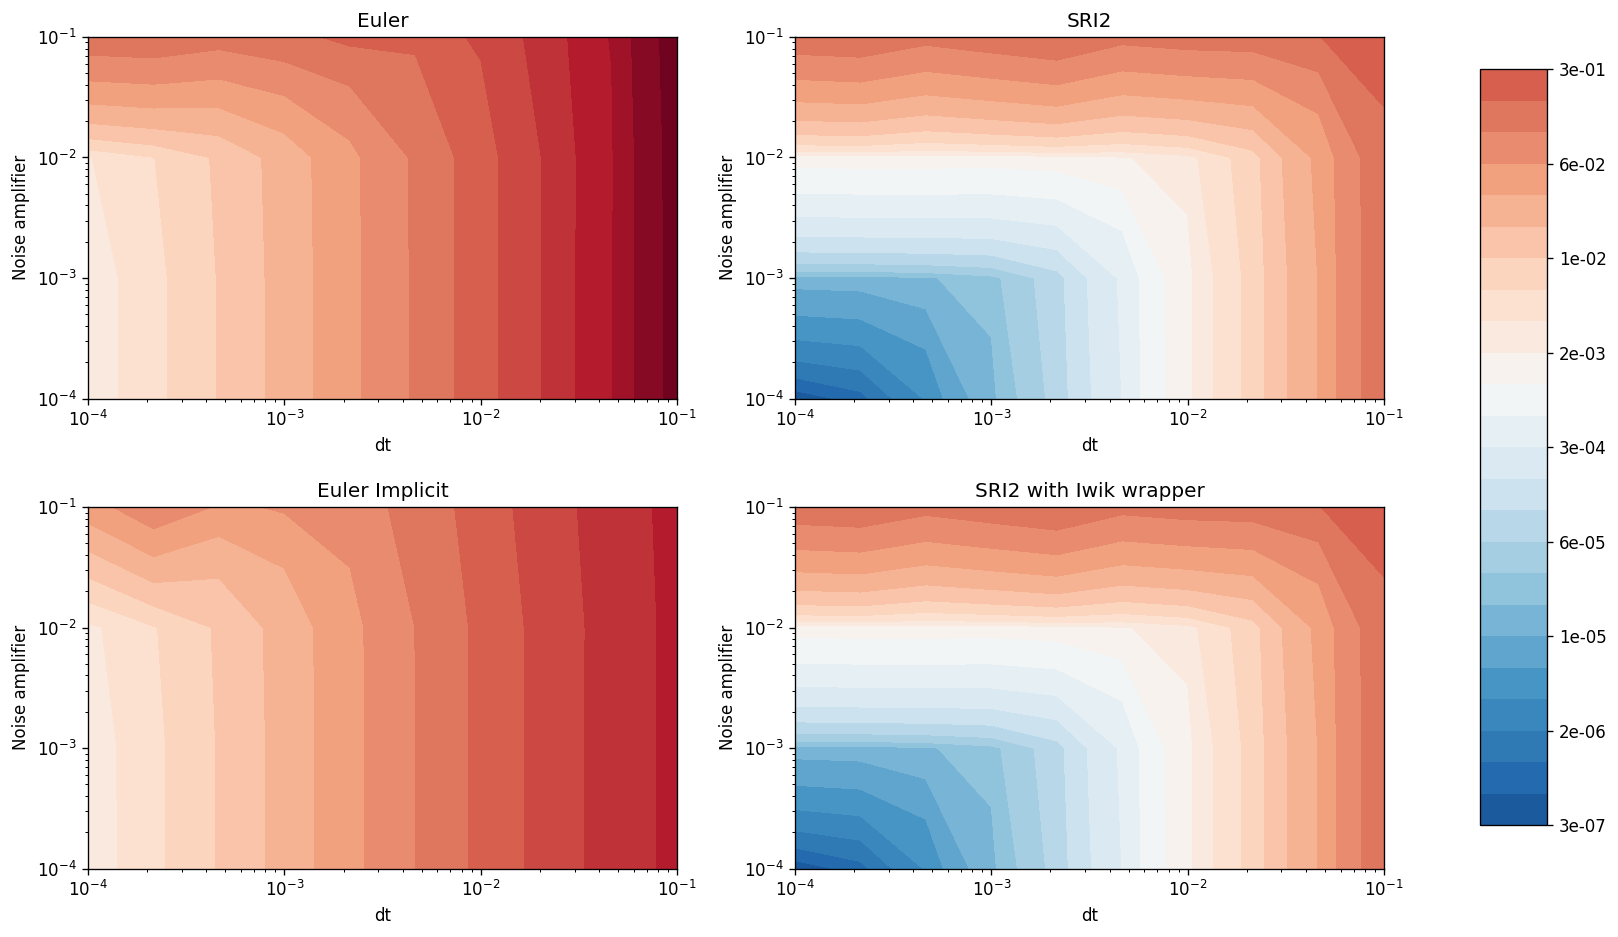

In [82]:
from matplotlib import ticker, cm

fig, ax = plt.subplots(2,2, figsize=(16, 9))
fig.set_dpi(120)
css = []
cmap_reversed = cm.get_cmap('RdBu_r')
for a, dat, name in zip(ax.flatten(), data, names):
    cs = a.contourf(Dt, Namp, dat, levels=20, locator=ticker.LogLocator(subs=np.logspace(-1, 0, 5)[1:]), cmap=cmap_reversed, vmin=1e-7, vmax=10.)
    a.set_title(name)
    css.append(cs)
    #fig.colorbar(cs, format="{x:.0e}")

    a.set_xscale("log")
    a.set_yscale("log")
    a.set_xlabel("dt")
    a.set_ylabel("Noise amplifier")
    
fig.subplots_adjust(right=0.8, hspace=0.3)
cbar_ax = fig.add_axes([0.85, 0.15, 0.035, 0.7])
fig.colorbar(cs, cax=cbar_ax, format="{x:.0e}")    
    
#fig.tight_layout(pad=2.)
plt.savefig("Error vs noise multiplier and time step.pdf")